In [1]:
import sys
path = '/lustre/home/pr5739/qualikiz/UKAEAGroupProject/src/'
path2 = '/lustre/home/pr5739/qualikiz/UKAEAGroupProject/src/scripts'
sys.path.append(path)
sys.path.append(path2)
import numpy as np 
import pandas as pd
import h5py as h5
import seaborn as sns
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['axes.linewidth']=5
plt.rcParams['xtick.major.size'] =15

plt.rcParams['ytick.major.size'] =15
plt.rcParams['xtick.minor.size'] =10
plt.rcParams['ytick.minor.size'] =10
plt.rcParams['xtick.major.width'] =5
plt.rcParams['ytick.major.width'] =5
plt.rcParams['xtick.minor.width'] =5
plt.rcParams['ytick.minor.width'] =5
plt.rcParams['axes.titlepad'] = 10

plt.rcParams['font.size']=55
plt.rcParams['figure.figsize']=(10,10)



from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score
import torch
from scripts.utils import train_keys
from scripts.Classifier import Classifier, ClassifierDataset
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import comet_ml

from pytorch_lightning.loggers import CometLogger
from sklearn.preprocessing import StandardScaler

NameError: name 'plt' is not defined

In [12]:
datapath = "/lustre/home/pr5739/qualikiz/UKAEAGroupProject"

# Analysis

In [9]:
checkpoint = f'{path}/../logs/classifier_for_jonathan/correct_checkpoints/experiment_name=0-epoch=15-val_acc=0.78.ckpt'
#1/experiment_name=0-epoch=48-val_loss=0.46.ckpt'
model = Classifier.load_from_checkpoint(checkpoint)

In [15]:
train = pd.read_pickle(f'{datapath}/data/valid_unstable/train.pkl')
val = pd.read_pickle(f'{datapath}/data/valid_unstable/valid.pkl')
test = pd.read_pickle(f'{datapath}/data/valid_unstable/test.pkl')    


In [16]:
X_train = train[train_keys]
Y_train = train['invalid_unstable']
X_val = val[train_keys]
Y_val = val['invalid_unstable']
X_test = test[train_keys]
Y_test = test['invalid_unstable']

In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [20]:
#ds_test = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(Y_test).int())
#dl_test = torch.utils.data.DataLoader(ds_test, batch_size=256, shuffle=False, num_workers=16)

predictions = model(torch.tensor(X_test, dtype=torch.float)).detach().numpy()


In [39]:
test_pred = np.where(predictions < 0.5, predictions, 1)
test_pred = np.where(predictions >= 0.5, test_pred, 0)

n_positive = np.where(Y_test ==0)[0].shape[0]
n_negative = np.where(Y_test ==1)[0].shape[0]
div_arr = np.array([[n_positive, n_negative]]).T

### metrics

In [40]:
accuracy = accuracy_score(Y_test, test_pred)
F1 = f1_score(Y_test, test_pred)
precision = precision_score(Y_test, test_pred)
recall =recall_score(Y_test,test_pred)

print('For test set:')
print(f'accuracy: {accuracy}\nF1; {F1}\nprecision: {precision}\nrecall:{recall}')

For test set:
accuracy: 0.7698059295309059
F1; 0.7186196780926841
precision: 0.7509296040340281
recall:0.6889754279104987


ROC AUC:0.7594643751170698


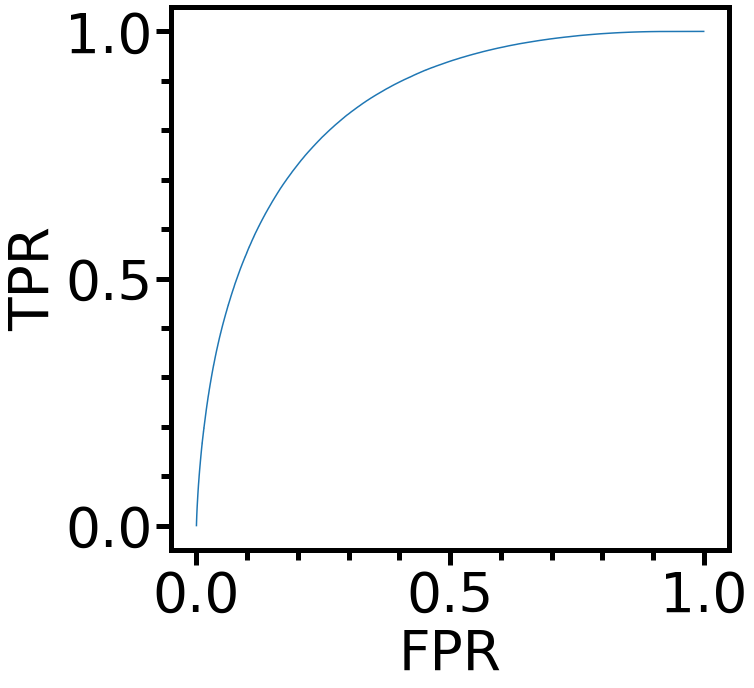

In [45]:
fpr,tpr,_ = roc_curve(Y_test,predictions)
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
print(f'ROC AUC:{roc_auc_score(Y_test,test_pred)}')

[Text(0.5, 1.0, 'Confusion Matrix'),
 Text(0.5, 13.5, 'Predicted'),
 Text(13.499999999999986, 0.5, 'Actual')]

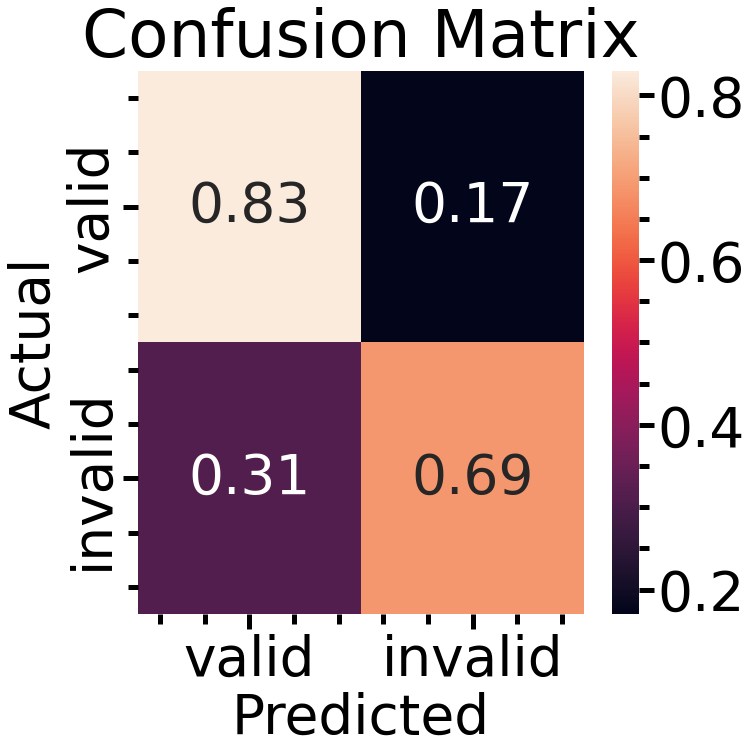

In [46]:
con_mat = confusion_matrix(Y_test, test_pred, labels =[0,1])/div_arr
sns.heatmap(con_mat, annot=True, xticklabels=['valid','invalid'], yticklabels=['valid','invalid']).set(title='Confusion Matrix', xlabel='Predicted', ylabel='Actual')